In [1]:
import sys
sys.path.insert(0, "/home/jupyter/ML_for_slideseq")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier import util_data

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.style.use("seaborn")
mpl.rcParams["figure.dpi"] = 200

In [4]:
root = "/home/jupyter/data/slide-seq/original_data/"

df_wt1 = pd.read_csv(root + "wt_1.csv")
df_wt2 = pd.read_csv(root + "wt_2.csv")
df_wt3 = pd.read_csv(root + "wt_3.csv")
df_dis1 = pd.read_csv(root + "sick_1.csv")
df_dis2 = pd.read_csv(root + "sick_2.csv")
df_dis3 = pd.read_csv(root + "sick_3.csv")

all_df = [df_wt1, df_wt2,df_wt3, df_dis1, df_dis2, df_dis3]

In [5]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 100
input_size = 224
num_ftrs = 128
pixel_size = 5
crop_size = 224
input_channels = 9
n_element_min = 200

In [27]:
all_df = [df_wt2, df_dis2]

sparse_images = [
    util_data.SparseImage.from_panda(
        df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
    ) 
    for df in all_df
]


labels_sparse_images = [0, 1]
n_crops_test = 200

testdata_transform = torchvision.transforms.Compose([
    util_data.StackTensor(dim=-4),
    util_data.RandomGaussianBlur(sigma=(1.0, 1.0)),
    torchvision.transforms.Resize(input_size)
])

testdataset = util_data.SparseDataset(
    x=util_data.RandomCropSparseTensor(
        n_crops=n_crops_test,
        crop_size=crop_size,
        n_element_min=n_element_min,
        test_cache_key="test"
    )(sparse_images), 
    y=util_data.Interleave(n_repeat=n_crops_test)(labels_sparse_images)
)

dataloader_test = util_data.DataLoaderWithLoad(
    testdataset,
    batch_size=batch_size,
    collate_fn=util_data.SpecialCollateFn(transform=testdata_transform, simclr_output=False),
    shuffle=False
)

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])


In [7]:
all_df = [df_wt1, df_wt3, df_dis1, df_dis3]

sparse_images = [
    util_data.SparseImage.from_panda(
        df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
    ) 
    for df in all_df
]
labels_sparse_images = [0, 0, 1, 1]
n_crops_train = 400

sparse_dataset_train = util_data.SparseDataset(
    x=util_data.RandomCropSparseTensor(
        n_crops=n_crops_train,
        crop_size=crop_size,
        n_element_min=n_element_min,
    )(sparse_images), 
    y=util_data.Interleave(n_repeat=n_crops_train)(labels_sparse_images)
)

train_transform = torchvision.transforms.Compose([
    util_data.StackTensor(dim=-4),
    util_data.RandomGaussianBlur(sigma=(1.0, 1.0)),
    torchvision.transforms.Resize(input_size)
])

dataloader_train = util_data.DataLoaderWithLoad(
    sparse_dataset_train,
    batch_size=sparse_dataset_train.__len__(),
    collate_fn=util_data.SpecialCollateFn(transform=train_transform, simclr_output=False),
    shuffle=False
)

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 938, 939])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 940, 940])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 937, 940])
number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 928, 928])


In [8]:
import pytorch_lightning as pl
import torch
from tissue_purifier import loss as loss_functions


class Classifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        # create a moco based on ResNet
        self.resnet_moco = model

        # freeze the layers of moco
        for p in self.resnet_moco.parameters():  # reset requires_grad
            p.requires_grad = False

        # we create a linear layer for our downstream classification
        # model
        self.fc = nn.Linear(128, 2)
        self.loss = loss_functions.NoisyLoss()

        self.accuracy = pl.metrics.Accuracy()

    def forward(self, x):
        with torch.no_grad():
            y_hat = self.resnet_moco.backbone(x).squeeze()
            y_hat = nn.functional.normalize(y_hat, dim=1)
        
        y_hat = self.fc(y_hat)
        return y_hat


    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
#         loss = nn.functional.cross_entropy(y_hat, y)
        self.log('train_loss_fc', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        self.accuracy(torch.softmax(y_hat, dim=-1), y)
        self.log('val_acc', self.accuracy.compute(), on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
#         optim = torch.optim.SGD(self.fc.parameters(), lr=30.)
        optim = torch.optim.Adam(self.fc.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [9]:
from pytorch_lightning.loggers import NeptuneLogger


neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjNhOTY3ZS1mOGU2LTQ2ZGItYTFmOS01MGY4ZDdiNGU1YTcifQ==",
    project_name='fedorgrab/slide-seq-contrastive',
    experiment_name="Linear Classifier of Embeddings",
    tags=["Embedding Classification"]
)

NeptuneLogger will work in online mode


In [10]:
from torch import nn
import torchvision

resnet = torchvision.models.resnet18()
last_conv_channels = list(resnet.children())[-1].in_features
first_conv_out_channels = list(resnet.children())[0].out_channels
backbone = torch.nn.Sequential(
    torch.nn.Conv2d(input_channels, first_conv_out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    *list(resnet.children())[1:-1],
    torch.nn.Conv2d(last_conv_channels, num_ftrs, 1),
)

ckpt = torch.load("model.pth")
backbone.load_state_dict(ckpt["resnet18_parameters"])
# create the SimCLR model using the loaded created backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

In [11]:
model.eval()
classifier = Classifier(model=model)

In [15]:
gpus = 1

trainer = pl.Trainer(max_epochs=400, gpus=gpus, progress_bar_refresh_rate=25, logger=neptune_logger, log_every_n_steps=1)
trainer.fit(classifier, dataloader_train, dataloader_test)
print("DONE")

DONE


In [22]:
classifier = classifier.cuda()

In [36]:
y_true = []
y_probas = []
indicies = []

for batch, labels, fnames in dataloader_test:
    y_true.append(labels.cpu().detach().numpy())
    y_probas.append(torch.softmax(classifier(batch), dim=-1).cpu().detach().numpy()[:, 1])
    indicies.append(fnames)

In [37]:
y_probas = np.concatenate(y_probas)
y_true = np.concatenate(y_true)
indicies = np.concatenate(indicies)

In [43]:
from sklearn.preprocessing import minmax_scale 


def get_dense_image(df):
    t = util_data.RandomGaussianBlur(sigma=(1.0, 1.0))(
        util_data.SparseImage.from_panda(
            df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
        ).to_dense()
    )
    
    a = np.zeros(t.shape)
    for i in range(9):
        a[i] = minmax_scale(t[i].cpu())
        
    return a.transpose((1, 2, 0))

In [44]:
img_wt2 = get_dense_image(df_wt2)
img_dis2 = get_dense_image(df_dis2)

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])


In [45]:
from simple_cache import cache

offset = 0
CROP_SIZE = 224

def get_sickness_mask(image, image_label):
    intensity_mask = np.zeros(image.shape[:-1])
    count_mask = np.zeros(image.shape[:-1])
    xys = cache["test"]
    for i, (proba, real_answer) in enumerate(zip(y_probas, y_true)):
        if real_answer == image_label:
            crop_i, crop_j = xys[indicies[i]]
            intensity_mask[
                crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset
            ] += proba
            count_mask[crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset] += 1
            
#     count_mask = np.where(count_mask > 10, count_mask, 0)    
    return intensity_mask / (count_mask + 0.0000000001), count_mask

In [50]:
mask_1, _ = get_sickness_mask(img_dis2, 1)
mask_1 = np.where(mask_1 > 0.5, 1, 0)

mask_2, _ = get_sickness_mask(img_wt2, 0)
mask_2 = np.where(mask_2 > 0.5, 1, 0)

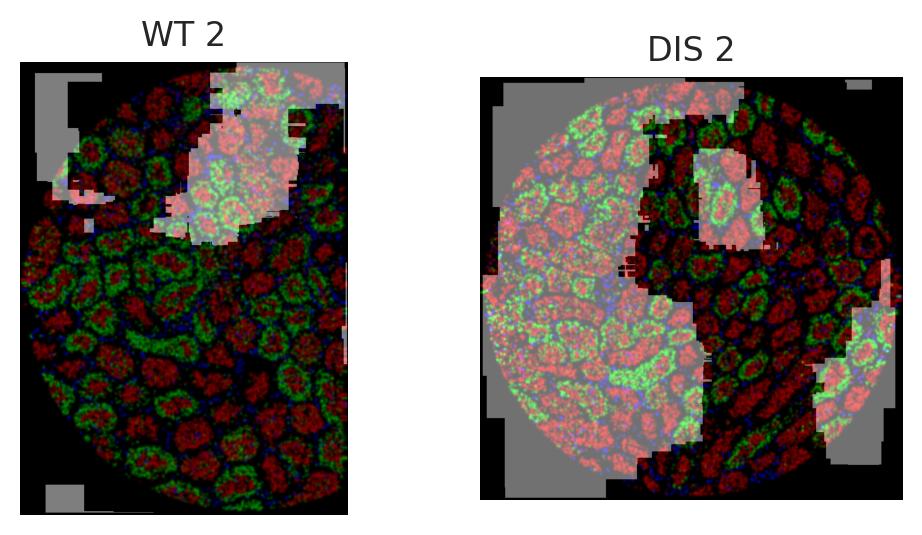

In [51]:
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax2.imshow(img_wt2[:, :, :3])
ax2.imshow(mask_2, alpha=0.5, cmap="gray")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("WT 2");

ax1.imshow(img_dis2[:,:,:3])
ax1.imshow(mask_1, alpha=0.45, cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("DIS 2");

In [53]:
sparse_image = util_data.SparseImage.from_panda(df_wt2, x="x", y="y", category="cell_type", pixel_size=4.0, padding=10) 

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 1170, 845])


In [56]:
transform_for_tiling = torchvision.transforms.Compose([
    util_data.StackTensor(dim=-4),
    util_data.RandomGaussianBlur(sigma=(1.0, 1.0)),
    torchvision.transforms.Resize(input_size)
])

output, counter = sparse_image.classify_with_tiling(
    patch_size=40,
    stride=20,
    classifier=classifier,
    transform=transform_for_tiling,
    n_element_min=10
)

Due to overlapping windows each region will be processed AT MOST 4 times
The classifier will process 2033 patches in 64 minibatches
0 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
10 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
20 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
30 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
40 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
50 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
60 out of 63 -> minibatch.shape = torch.Size([32, 9, 224, 224])
63 out of 63 -> minibatch.shape = torch.Size([17, 9, 224, 224])


In [62]:
plt.style.use("default")
mpl.rcParams["figure.dpi"] = 200

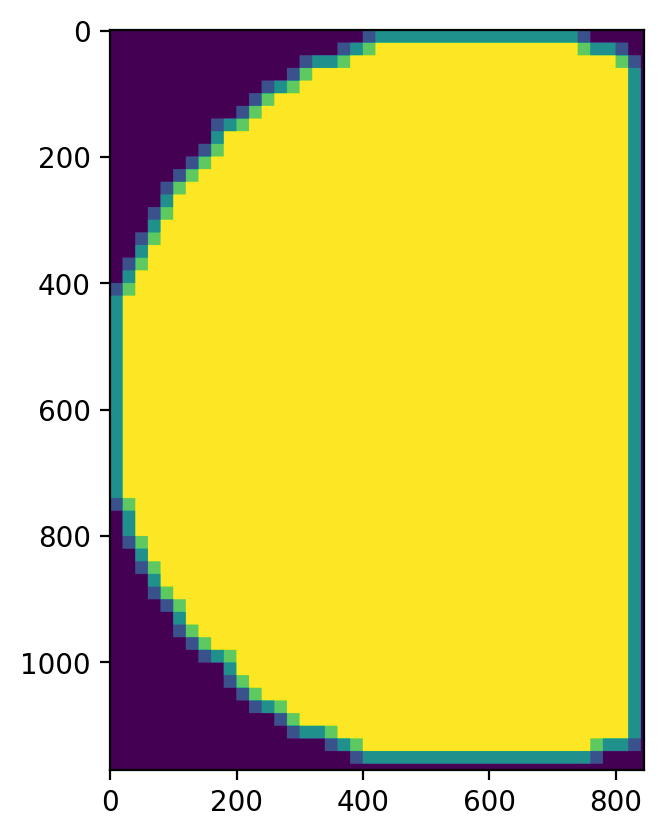

In [63]:
plt.imshow(counter[0].cpu())

In [64]:
av_classifier = torch.where(counter==0, torch.zeros_like(output), output/counter)

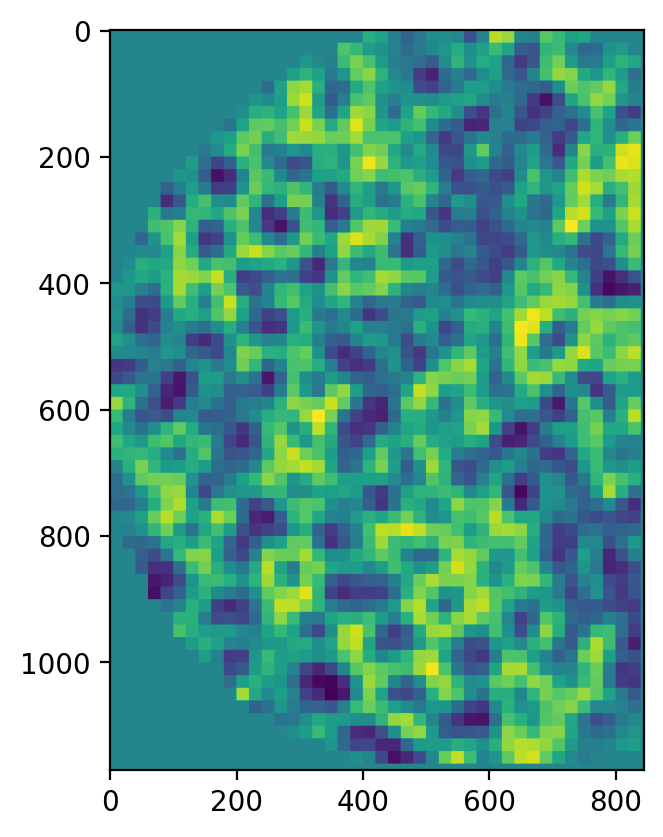

In [65]:
plt.imshow(av_classifier[0].cpu())